In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,plot_confusion_matrix
# from mlxtend.plotting import plot_decision_regions

In [4]:
# Import the data

# The column names are not included in the .data file so we must create an array of the column names and add them
colnames = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', '50k-Prediction']

# Create a panda dataframe from adult.data and add column names
df = pd.read_csv("adult.data", names=colnames)

# Print out the top 20 instances from the dataframe
print(df.head(20))

    age          workclass  fnlwgt      education  education-num  \
0    39          State-gov   77516      Bachelors             13   
1    50   Self-emp-not-inc   83311      Bachelors             13   
2    38            Private  215646        HS-grad              9   
3    53            Private  234721           11th              7   
4    28            Private  338409      Bachelors             13   
5    37            Private  284582        Masters             14   
6    49            Private  160187            9th              5   
7    52   Self-emp-not-inc  209642        HS-grad              9   
8    31            Private   45781        Masters             14   
9    42            Private  159449      Bachelors             13   
10   37            Private  280464   Some-college             10   
11   30          State-gov  141297      Bachelors             13   
12   23            Private  122272      Bachelors             13   
13   32            Private  205019     Assoc-acd

In [5]:
# Data preprocessing

# Remove duplicate data rows
df.drop_duplicates()

# Label Encoder is used to take all of our string data and asssign it a unique integer value
le = LabelEncoder()

# Using .fit_transform function to fit label
# encoder and return encoded label
# example, male/female will be turned into 0 and 1 for knn to calculate distance from
df['workclass'] = le.fit_transform(df['workclass'])
df['education'] = le.fit_transform(df['education'])
df['marital-status'] = le.fit_transform(df['marital-status'])
df['occupation'] = le.fit_transform(df['occupation'])
df['relationship'] = le.fit_transform(df['relationship'])
df['race'] = le.fit_transform(df['race'])
df['sex'] = le.fit_transform(df['sex'])
df['native-country'] = le.fit_transform(df['native-country'])
df['50k-Prediction'] = le.fit_transform(df['50k-Prediction'])  # Under 50k = 0, Over 50k = 1

# Print out the top 20 instances from the dataframe to show how LabelEncoder changed our data
print(df.head(20))

# Uncomment the .iloc[] lines if the program is running too slow. Will reduce dataset by 2/3.
x = df.drop('50k-Prediction', axis=1)   # all columns except 50k Prediction column (or classifier)
x10000 = x.iloc[:10000,].values              # Set sample amount to first 10000 rows

y = df['50k-Prediction']                # only the 50k Prediction column (or classifier),
y10000 = y.iloc[:10000,].values              # Set sample amount to first 10000 rows

# Need to normalize our data so 0/1 values are weighted the same as 0-50 values
# Dont need to normalize our y data because it is only 0s and 1s.
print(type(x))
x = preprocessing.scale(x)
print(type(x))
x = pd.DataFrame(x)
print(type(x))
x10000 = preprocessing.scale(x10000)

    age  workclass  fnlwgt  education  education-num  marital-status  \
0    39          7   77516          9             13               4   
1    50          6   83311          9             13               2   
2    38          4  215646         11              9               0   
3    53          4  234721          1              7               2   
4    28          4  338409          9             13               2   
5    37          4  284582         12             14               2   
6    49          4  160187          6              5               3   
7    52          6  209642         11              9               2   
8    31          4   45781         12             14               4   
9    42          4  159449          9             13               2   
10   37          4  280464         15             10               2   
11   30          7  141297          9             13               2   
12   23          4  122272          9             13            

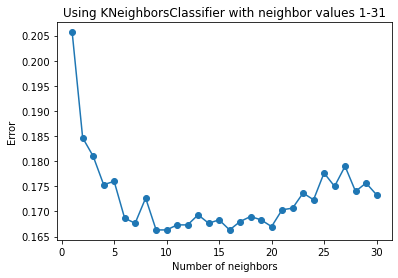

Lowest Error is with n neighbor value: 9


In [6]:
# Because KNN is a supervised classifier, split dataset into training set and test set
# The X_train and y_train variables will be the 70% of the data, while X_test and y_test will be the 30%.
# X_train and y_train will create the model, then X_test will be plugged into the model which will produce the prediction for y_test values.
# Then we will compare the y_prediction values to the y_test values to determine the accuracy.
# We use x10000 and y10000 becuase these variables will be used 30 times to calculate the optimal neighbor value, hence we need a smaller training set so it can runn efficiently
X_train, X_test, y_train, y_test = train_test_split(x10000, y10000, test_size=0.3,random_state=1234)  # 70% training and 30% test


# Determine the optimal amount of clusters using Error graph
# The biggest bend in the elbow determines which number of neighbors creates greatest difference in error reduction
Error = []  # will keep track of Error percentage for each n value
for n in range(1,31):  # calculate 30 different error values
    knnData = KNeighborsClassifier(n_neighbors=n)  # Uses KNeighborsClassifier to
    knnData = knnData.fit(X_train,y_train)  # Use train data to create a model
    y_pred = knnData.predict(X_test)  # Predict the y values with x_test values
    Error.append(1-accuracy_score(y_test,y_pred))  # Compare the y_pred values to the y_test actual values to find Error

plt.plot(range(1,31),Error, marker='o') # Plot the 30 different error calculations
plt.title("Using KNeighborsClassifier with neighbor values 1-31")
plt.xlabel("Number of neighbors")
plt.ylabel("Error")
plt.show()

# will print the index/n_neighbor value where the error is the lowest. Each time the data is randomly selected, so it will change each time it is run
best_n = Error.index(min(Error))+1
print(f"Lowest Error is with n neighbor value: {best_n}")

In [7]:
# Main KNN Calculation:

# Show that x and y are full data set -> 32k instances
print(f"Length of x data = {len(x)}")
print(f"Length of y data = {len(y)}")

# Using Kfolding to create a better estimate by averaging 5 testing and training sets
k = 5  # Do 5 folds, and split the set into 80/20
kfold = KFold(n_splits=k, random_state=1234, shuffle=True)
knnclassifier = KNeighborsClassifier(n_neighbors=best_n) # Note the use of best_n

acc_score = []

# For loop that will calculate the KNeighbors Classifier 5 times using 5 different folds of the training and testing
# data, then average the results.
for train_index, test_index in kfold.split(x):
     x_train, x_test = x.iloc[train_index,:], x.iloc[test_index,:]
     y_train, y_test = y[train_index], y[test_index]

     knnclassifier.fit(x_train,y_train)
     y_pred = knnclassifier.predict(x_test)

     acc = accuracy_score(y_pred, y_test)
     acc_score.append(acc)

avg_acc_score = sum(acc_score)/k

print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

Length of x data = 32561
Length of y data = 32561
accuracy of each fold - [0.8274220789190849, 0.8329238329238329, 0.8361486486486487, 0.8381449631449631, 0.8356879606879607]
Avg accuracy : 0.8340654968648981


In [8]:
# Create a confusion matrix of the y_test values(correct answers) to the y_pred values(predicted values)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)
# Results from confusion matrix:
print("6922 true positives")
print("1158 true negatives")
print("547 false negatives")
print("1142 false positives")


# Precision-> True Positives / (True Positives + False Positives)
# How correct was the prediction?
# 88% salary under 50k
# 67% salary over 50k
# Averaging the two, the chance to identify is 78%, with a weighted 83% chance

# Recall-> True Positives / (True Positives + False Negatives)
# A measure of the models completeness. How many positive cases were found?
# 91% of cases were found if salary is less than 50k
# 58% of cases were found if salary is over 50k
# 75% average cases found with a weighted 84% rate

# f1-score- F1 Score = 2*(Recall * Precision) / (Recall + Precision)
# What percent of positive predictions were correct?
# 89% for salary <50k
# 62% for salary > 50k
# Accuracy of 84% to determine if a person has a salary over/under 50k

print(classification_report(y_test,y_pred))

#Resources Used
# https://muthu.co/understanding-the-classification-report-in-sklearn/
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


[[4553  432]
 [ 638  889]]
6922 true positives
1158 true negatives
547 false negatives
1142 false positives
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4985
           1       0.67      0.58      0.62      1527

    accuracy                           0.84      6512
   macro avg       0.78      0.75      0.76      6512
weighted avg       0.83      0.84      0.83      6512

